## Test SPIM data CEBRA model

- Use CEBRA label contrastive learning on neural data from one fish
    - design model
    - convert SPIM data to usable format 
    - load data
    - fit with label
    - plot embeddings
    - try to predict stimulus presence
    - try to decode stimulus type (left/right spots)
        - create a discrete variable that labels the post-stimulus frames for right and left spots
        - This should inform the decoder to separate embedding states (which should vary between left and right spots)<br/><br/>

### CEBRA-Time

In [1]:
%matplotlib ipympl
import cebra
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from pathlib import Path


In [2]:
### define globals ### 

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global TIME_OR_TIME_DELTA      # choose between time-contrastive or label-contrastive paradigm
global LABEL                   # brief description of model training label
global EXTRA_LABEL             # optional extra information to include in model name
global FILEPATH                # path to data file
global DATA_PATH               # path to experimental data
global MODELPATH_ROOT          # folder path for models folder
global MODELPATH_DATE          # specific path within models folder
global MODEL_VER               # append version to model name for when saving multiple repeats
global TIMESTEPS               # no. of neural timepoints to use
global ROIS                    # no. of ROIs to use 
global ITERS                   # model training iterations
global LOAD_DATA               # attempt to load pre-saved .npz data files
global SAVE_DATA               # save new .npz files when created
global LOAD_MODEL              # attempt to load model
global SAVE_MODEL              # save model to models folder
global SAVE_FIGS               # automatically save figures generated
global SAVE_FIGS_LABEL         # extra label to be added to figure names as they are saved
global STIM_TYPES              # dictionary of stim types to stim numbers
global STIMS                   # relevant stims for model
global TRAINING_TEST_SPLIT     # split fraction for embedding model
global STIM_LENGTH_FRAMES      # the length in frames of stimuli, assuming all stimuli have equal duration
global HALF_STIM_MASK          # only use the second half of stimuli for training the model
global PREDICT_ON_TRAIN        # for decoder, do both training and prediciton on the training set
global RESTRICT_TO_TECTAL      # get random subset of neurons from the tectal mask only
global SIGNAL_TYPE             # whether to use deconvolved calcium or raw calcium

TIME_OR_TIME_DELTA = 'time'
LABEL = ''                                                          # set as '' for time-contrastive
EXTRA_LABEL = 'second-half-stims_deconv'
FILEPATH = dat_files[1]
DATA_PATH = '/home/tomh/Documents/projects/czebra/test_notebooks/data/'
MODELPATH_ROOT = '/home/tomh/Documents/projects/czebra/archived_models/'
MODELPATH_DATE = '230911/'
MODEL_VER = 1
TIMESTEPS = None                                                        # set as None to use all timepoints
ROIS = 10000
ITERS = 2000
LOAD_DATA = False
SAVE_DATA = True
LOAD_MODEL = False
SAVE_MODEL = True
SAVE_FIGS = True
STIM_TYPES = {'left_spot':0, 'right_spot':1,  \
              'open_loop_grating':2, 'closed_loop_grating':3}
STIMS = ['left_spot', 'right_spot']
TRAINING_TEST_SPLIT = 0.8
STIM_LENGTH_FRAMES = 22
HALF_STIM_MASK = True
PREDICT_ON_TRAIN = False
RESTRICT_TO_TECTAL = False
SAVE_FIGS_LABEL = 'predict-on-train_' if SAVE_FIGS and PREDICT_ON_TRAIN else ''
SIGNAL_TYPE = 'deconv'        # dfof for raw, deconv for deconvolved


In [3]:
### define model ###

parameters = {'conditional':TIME_OR_TIME_DELTA,
              'max_iterations':ITERS,
              'batch_size':1024,
              'num_hidden_units':128,
              'weight_decay':1e-03,
              'rois':ROIS,
             }

cebra_stim_on_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional=parameters['conditional'],
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=parameters['max_iterations'],
    max_adapt_iterations=500,
    batch_size=parameters['batch_size'],
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=parameters['num_hidden_units'],
    hybrid=False,
    optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08), ('weight_decay', parameters['weight_decay']), ('amsgrad', False))
    )
print(cebra_stim_on_model)

CEBRA(batch_size=1024, conditional='time', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      num_hidden_units=128,
      optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08),
                        ('weight_decay', 0.001), ('amsgrad', False)),
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


In [4]:
### load data for a single fish ###
# if LOAD == True, load pre-saved .npz file data. Otherwise,
# create this data as specified below and save it to .npz

##  params ##

# variables
stim_types = STIM_TYPES     # dict of all possible stims
stims = STIMS               # stim types chosen for analysis
timesteps = TIMESTEPS
rois = ROIS
stim_length_frames = STIM_LENGTH_FRAMES # used for selecting the second half of stimuli

start, stop = 0, timesteps
load_data = LOAD_DATA
save_data = SAVE_DATA

# paths
filepath = FILEPATH
filename = filepath.split('/')[-1][:-3] # fish and date only
data_folder = DATA_PATH
data_folder_HDD = '/media/storage/DATA/tom/'
filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames.npz'
filename_neural_subset = f'{filename[-9:]}_{SIGNAL_TYPE}_subset.npz'
filename_neural_indexes = f'{filename[-9:]}_neural_indexes_all.npz'

# specify loading anatomically unrestricted data or tectal-restricted data
if RESTRICT_TO_TECTAL:
    filename_neural_subset = f'{filename[-9:]}_{SIGNAL_TYPE}_subset_tectal.npz'
    filename_neural_indexes = f'{filename[-9:]}_neural_indexes_tectal.npz'

# if not loading data, but not wanting to overwrite saved data, save as a temp file
if not save_data and not load_data: 
    print(f"Producing temp files...")
    filename_neural = f'{filename[-9:]}_{SIGNAL_TYPE}_TEMPORARY_DELETE.npz'
    filename_neural_subset = f'{filename[-9:]}_{SIGNAL_TYPE}_subset_TEMPORARY_DELETE.npz'
    filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames_TEMPORARY_DELETE.npz'


print("Accessing data...")

if load_data:
    
    ## load data ##
    
    # Attempt to load neural data from .npz, otherwise load from HDD .h5
    # Load small datasets from .npz files
    print("Loading data...")
    
    # neural
    try:
        key = "neural"
        ## loading full dataset from HDD
        # neural = cebra.load_data(filepath, key='rois/deconv')
        ## loading full dataset from SSD
        # neural = cebra.load_data(f"{data_folder}{filename_deconv}", key=key)
        # loading subset of dataset that was just created and saved
        neural = cebra.load_data(f"{data_folder}{filename_neural_subset}", key=key)
        print("Neural data loaded")

    except:
        print(f"Could not neural data from file {data_folder}{filename_neural_subset} under key {key}.")
        # try:
        #     neural = cebra.load_data(filepath, key='rois/deconv')
        #     print("Full neural data loaded from HDD file.")

        # except Exception as e:
        #     print("Could not load data.")
        #     print(e)
    
    # auxiliary variables
    stim_on_frames = cebra.load_data(f'{data_folder}{filename_stim_pres_frames}', key="stim_on_frames")
    print(f"Stimulus presentation frames loaded.")
    print("All data loaded.")

# else if not load data
else:
    with h5py.File(filepath, 'r') as f:

            ## neural ##
            # take either deconvolved or raw calcium signal ('deconv' or 'dfof')
            neural = f['rois'][f'{SIGNAL_TYPE}']
            print(f"Full neural dataset shape is: {neural.shape}")

            # decide whether to sample from all neurons, or tectal neurons only
            if RESTRICT_TO_TECTAL:
                
                print("Taking tectal neurons only.")
                tectal_mask = f['rois']['anat_label']['tectum_SPV_AZ'][:]
                neural_indexes = np.sort(
                                    np.random.choice(
                                                    np.where(tectal_mask)[0], size=rois, replace=False
                                                    )
                                        )
            else:
                
                # subset neural by selecting first TIMESTEPS timesteps and random ROIS rois
                neural_indexes = np.sort(
                                    np.random.choice(
                                                np.arange(neural.shape[1]), size=rois, replace=False
                                                )
                                    )
            
            # if a subset of timesteps is chosen, restrict data to this subset
            if timesteps:
                neural = np.array(neural[:timesteps, neural_indexes])
            else:
                neural = np.array(neural[:, neural_indexes])
                timesteps = neural.shape[0]

            print(f"Truncated dataset size: {neural.shape}")
            assert(neural.shape == (timesteps, rois))

            ## stimuli ##

            # get stimulus presentations
            stimuli = f['visuomotor']['presentations']
            stim_type = stimuli['stim_type'][:timesteps].astype(int)
            stim_on_fr = stimuli['onset_frame'][:timesteps].astype(int)
            stim_end_fr = stimuli['offset_frame'][:timesteps].astype(int)

            # initialise lists for the chosen stimuli
            (stim_pres_idx_list, stim_on_fr_list,
            stim_end_fr_list, stim_on_mask_list, stim_dur_list)  = [],[],[],[],[]


            # loop through chosen stimuli and find boolean masks for their 'on' frames
            for stim in stims:

                # convert stim name to stim number
                stim_num = stim_types[stim] 
                print(f'Attempting to parse stim: {stim}') 

                # find the presentation indexes for the specified stim type
                # must account for data index starting at 1
                this_stim_pres_indexes = np.where(np.isin(stim_type, stim_num + 1))[0]
                stim_pres_idx_list.append(this_stim_pres_indexes)

                # index stim onset frame numbers with the presentation indexes
                this_stim_on_frames = stim_on_fr[this_stim_pres_indexes]
                this_stim_on_frames = this_stim_on_frames[this_stim_on_frames < timesteps]

                # If taking only the second half of stimulus frames, increment the start frame
                # indexes by half the stimulus duration, to simulate the stimulus starting halfway
                # later than it actually does
                if HALF_STIM_MASK: 
                    print("Taking the second half of stimuli only.")
                    this_stim_on_frames = (this_stim_on_frames + stim_length_frames/2).astype(int)
                stim_on_fr_list.append(this_stim_on_frames)

                # index stim end frame numbers with the presentation indexes
                this_stim_end_frames = stim_end_fr[this_stim_pres_indexes]
                this_stim_end_frames = this_stim_end_frames[this_stim_end_frames < timesteps]
                stim_end_fr_list.append(this_stim_end_frames)

                # create a boolean mask of stimulus presentation frames (1 == stimulus on, 0 == stimulus off)
                this_stim_on_mask = np.zeros(neural.shape[0]).astype(int)
                this_stim_on_mask[[this_stim_on_frames, this_stim_end_frames]] = 1
                
                # perform bitwise XOR operation on consecutive elements of stim_on_mask. This will convert all 
                # but stim_off frame to 1s. Combining with "OR stim_on_mask" will also include the stim_off frame
                this_stim_on_mask = np.bitwise_xor.accumulate(this_stim_on_mask) | this_stim_on_mask
                stim_on_mask_list.append(this_stim_on_mask)

                # find duration (in frames) of each presentation of the stimulus
                # recording rate is 5 Hz
                stim_dur_list.append(this_stim_end_frames - this_stim_on_frames)

                # assert shapes
                print(f"Label shape: {stim_on_mask_list[0].shape}")
                assert(stim_on_mask_list[0].size == neural.shape[0])

                print(f'Stim type {stim} parsed successfully.')

            ## save data ##
            print("Saving data...")
            stim_on_mask_dataset = np.column_stack(stim_on_mask_list[:])

            assert(stim_on_mask_dataset.shape == (neural.shape[0], len(stims)))
            assert(neural.shape == (timesteps, rois))

            np.savez(f'{data_folder}{filename_stim_pres_frames}', stim_on_frames=stim_on_mask_dataset)
            print(f"Stim presentation dataset saved.")
            np.savez(f"{data_folder}{filename_neural_subset}", neural=neural)
            print(f"Neural dataset saved.")
            np.savez(f"{data_folder}{filename_neural_indexes}", neural_indexes=neural_indexes)
            print(f"All datasets saved.")

            ## load data ##
            # Attempt to load neural data from .npz, otherwise load from HDD .h5
            # Load small datasets from .npz files
            print("Loading data...")
            
            # neural
            try:
                key = "neural"
                ## loading full dataset from HDD
                # neural = cebra.load_data(filepath, key='rois/deconv')
                ## loading full dataset from SSD
                # neural = cebra.load_data(f"{data_folder}{filename_deconv}", key=key)
                # loading subset of dataset that was just created and saved

                neural = cebra.load_data(f"{data_folder}{filename_neural_subset}", key=key)
                print("Neural data loaded")

            except:
                print(f"Could not neural data from file {data_folder}{filename_neural_subset} under key {key}.")
                try:
                    neural = cebra.load_data(filepath, key='rois/deconv')
                    print("Full neural data loaded from HDD file.")

                except Exception as e:
                    print("Could not load data.")
                    print(e)
            
            # auxiliary variables
            stim_on_frames = cebra.load_data(f'{data_folder}{filename_stim_pres_frames}', key="stim_on_frames")
            print(f"Stimulus presentation frames loaded.")
            print("All data loaded.")

# end if-else

# format the discrete variable
# left spot == 1, right spot == 2, no stimulus == 0 
left_spot, right_spot = stim_on_frames[:,0], stim_on_frames[:,1]
right_spot = np.multiply(right_spot, 2)
discrete = np.add(left_spot, right_spot)

# separate data into training and test
training_test_split = TRAINING_TEST_SPLIT
split_idx = int(np.round(neural.shape[0] * training_test_split))
neural_train, neural_test = neural[:split_idx, :], neural[split_idx:, :]
discrete_train, discrete_test = discrete[:split_idx], discrete[split_idx:]

Accessing data...
Full neural dataset shape is: (38550, 101435)
Truncated dataset size: (38550, 10000)
Attempting to parse stim: left_spot
Taking the second half of stimuli only.
Label shape: (38550,)
Stim type left_spot parsed successfully.
Attempting to parse stim: right_spot
Taking the second half of stimuli only.
Label shape: (38550,)
Stim type right_spot parsed successfully.
Saving data...
Stim presentation dataset saved.
Neural dataset saved.
All datasets saved.
Loading data...
Neural data loaded
Stimulus presentation frames loaded.
All data loaded.


In [5]:
### load, fit, and save model ###
# if LOAD_MODEL == True, load the specified model. Otherwise, fit the model
# and additionally save it if SAVE_MODEL == True

modelpath_root = MODELPATH_ROOT
modelpath_date = MODELPATH_DATE

# create model name and full model path
model_name = 'f1_221103_spot-label_10000rois_2000iters_128hidden_1e-4L2'
model_name = f"{filename}_{LABEL}{'-label' if parameters['conditional'] == 'time_delta' else 'time'}_" + \
    f"{EXTRA_LABEL+'_' if EXTRA_LABEL else ''}" + \
    f"{ROIS}rois_{ITERS}iters_{parameters['num_hidden_units']}hidden_{parameters['weight_decay']}L2_" + \
    f"{TRAINING_TEST_SPLIT}train"
full_model_path = f"{modelpath_root}{modelpath_date}{model_name}/{model_name}_{MODEL_VER}.pt"
model_dir = f"{modelpath_root}{modelpath_date}{model_name}"

if LOAD_MODEL:

    ## load ##

    print("Loading model...")
    cebra_stim_on_model = cebra.CEBRA.load(full_model_path)
    print("Model loaded.")

    if SAVE_MODEL:

        ## save ##
        print("Saving model...")
        cebra_stim_on_model.save(full_model_path)
        print("Model saved.")

else:

    ## fit ## 

    print("Fitting model...")
    print(cebra_stim_on_model)

    if TIME_OR_TIME_DELTA == 'time':
        cebra_stim_on_model.fit(neural_train)
    else:
        cebra_stim_on_model.fit(neural_train, discrete_train)
    print("Model fit.")


if SAVE_MODEL and not LOAD_MODEL:
    
    ## save ##

    print("Saving model...")
    # create the directory if it does not already exist (and continue if it does)
    Path(f"{model_dir}").mkdir(parents=True, exist_ok=True)
    cebra_stim_on_model.save(full_model_path)
    print("Model saved.")


Fitting model...
CEBRA(batch_size=1024, conditional='time', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      num_hidden_units=128,
      optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08),
                        ('weight_decay', 0.001), ('amsgrad', False)),
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


pos:  0.0097 neg:  5.9326 total:  5.9424 temperature:  0.8003: 100%|██████████| 2000/2000 [04:53<00:00,  6.81it/s]


Model fit.
Saving model...
Model saved.


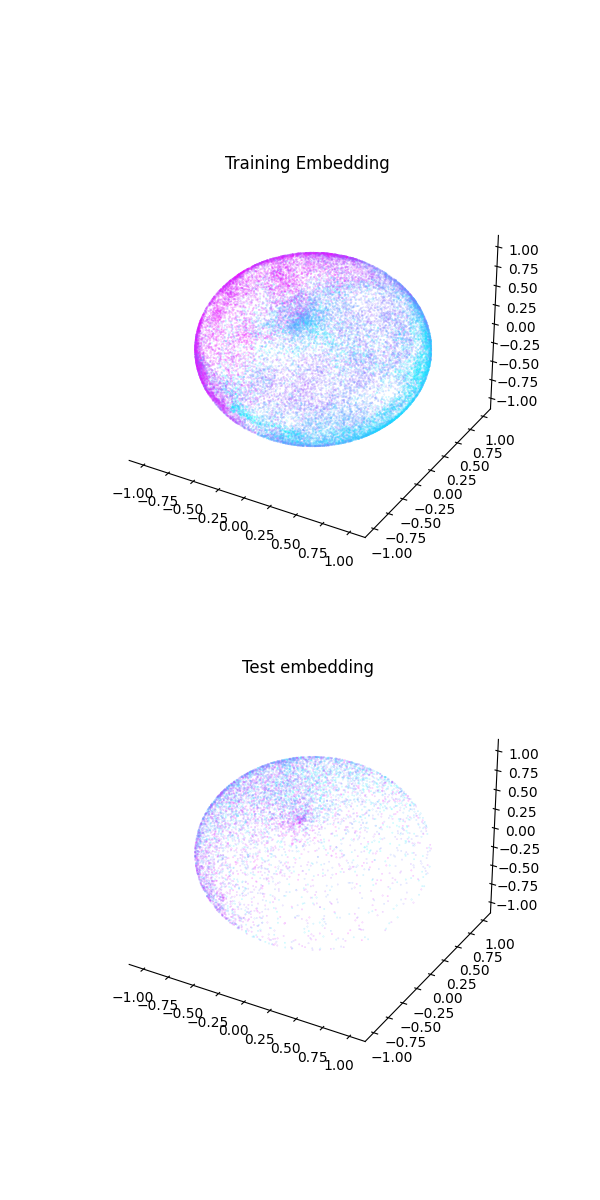

In [6]:
### generate/plot embeddings ###

# # CEBRA's plot_embedding function is bugged
fig = plt.figure(figsize=(6,12))
ax1 = plt.subplot(211, projection='3d')
ax2 = plt.subplot(212, projection='3d')

# trained embedding
embedding_train = cebra_stim_on_model.transform(neural_train)
cebra.plot_embedding(embedding=embedding_train, embedding_labels=np.arange(neural_train.shape[0]), ax=ax1, cmap='cool', title="Training Embedding")

# test embedding
embedding_test = cebra_stim_on_model.transform(neural_test)
cebra.plot_embedding(embedding=embedding_test, embedding_labels=np.arange(neural_test.shape[0]), ax=ax2, cmap='cool', title="Test embedding")

if SAVE_FIGS:
    # save this figure to the model folder
    plt.savefig(f"{model_dir}/v{MODEL_VER}_{SAVE_FIGS_LABEL}embeddings")

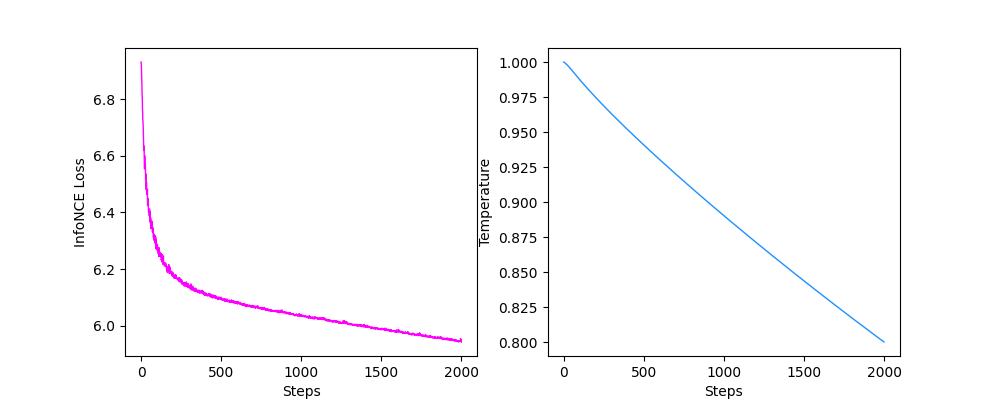

In [7]:
### plot loss and temperature ###

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

cebra.plot_loss(cebra_stim_on_model, ax=ax1)
cebra.plot_temperature(cebra_stim_on_model, ax=ax2)

if SAVE_FIGS:
    # save this figure to the model folder
    plt.savefig(f"{model_dir}/v{MODEL_VER}_{SAVE_FIGS_LABEL}loss-and-temp")


In [8]:
### Decode ###

decoder = cebra.KNNDecoder()

decoder.fit(embedding_train, discrete_train)

# decide whether to predict on the same embedding as trained on, or on the test embedding
if PREDICT_ON_TRAIN:
    # changed to predict on the training embedding
    predictions = decoder.predict(embedding_train)
    # also change what is considered the "test" set. In this case it will be the training set
    discrete_test = discrete_train
else:
    predictions = decoder.predict(embedding_test)

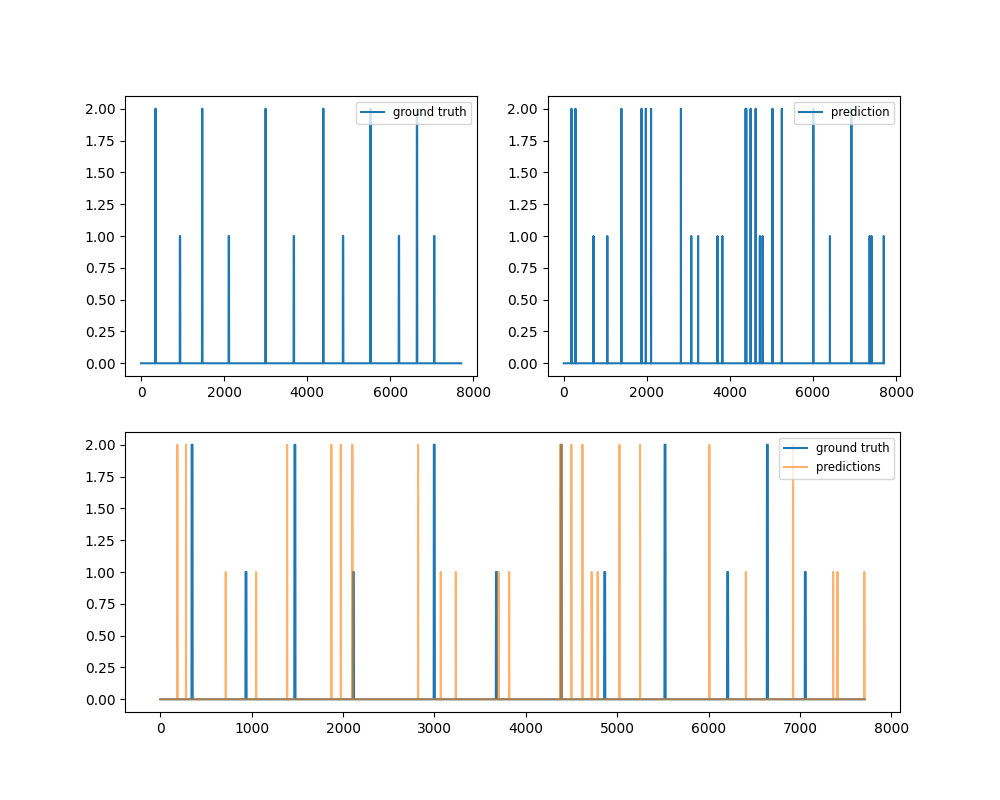

In [9]:
### visualise ###

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend(loc='upper right', fontsize='small')

ax2.plot(predictions, label='prediction')
ax2.legend(loc='upper right', fontsize='small')

ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')

# ax3.text(7100, 1.00, f"f1 :{f1_score:.2f}", fontsize='small')
# ax3.text(7100, 0.9, f"f1_len :{lenient_f1_score:.2f}", fontsize='small')
# ax3.text(7100, 0.75, f"len-non-bi :{f1_score:.2f}", fontsize='small')

if SAVE_FIGS:
    # save this figure to the model folder
    plt.savefig(f"{model_dir}/v{MODEL_VER}_{SAVE_FIGS_LABEL}predictions")

In [10]:
### FUNCTION ###
def create_lenient_predictions(test_data, prediction_data, stim_types, stim_length=22):
    ''' find the indexes where a prediction was made, and copy the ground truth
        for the relevant stimulus if this prediction lies within stimulus on '''
    
    leniency_range = stim_length*2
    predictions_lenient = np.zeros(prediction_data.size)

    stim_predictions = []
    for stim in stim_types:
        stim_predictions.append(np.where(np.isin(prediction_data, stim))[0])

    for i in range(len(stim_predictions)):
        # for each stimulus predicted
        prediction = stim_predictions[i]

        # for each index in current stimulus prediction
        for idx in prediction:
            # check if this is a correct prediction (ground-truth also the same stimulus category)
            if test_data[idx] == stim_types[i]:
                # for the leniency_range timepoints around the stimulus, copy any 1s from the ground truth to predictions
                upper_bound, lower_bound = np.ceil(idx+leniency_range/2).astype(int), np.ceil(idx-leniency_range/2).astype(int)
                predictions_lenient[lower_bound:upper_bound] = test_data[lower_bound:upper_bound]

    return predictions_lenient

In [11]:
### evaluate decoder performance - f1 score ###
# Also provide a lenient f1-score (where any prediction of a stimulus within 
# the stimulus duration counts as a fully accurate predictions)


## Define the test set ## 

training_test_split = TRAINING_TEST_SPLIT   
split_idx = int(np.round(neural.shape[0] * training_test_split))

if PREDICT_ON_TRAIN:
    # for this case, set "test" subset of neural to just be the training subset 
    # index stim_on mask to restrict data to the test subset
    left_spot, right_spot = stim_on_frames[:split_idx,0], stim_on_frames[:split_idx,1]
else:
    # index stim_on mask to restrict data to the test subset
    left_spot, right_spot = stim_on_frames[split_idx:,0], stim_on_frames[split_idx:,1]

# combine left and right spot stim_on mask
discrete_test_f1_binary = np.add(left_spot, right_spot)
discrete_test_f1 = np.add(left_spot, np.multiply(right_spot, 2))


## convert predictions to also all be the same value for binary f1-score ## 

idx_to_replace = np.where(np.isin(predictions, 2))[0]
predictions_binary = np.copy(predictions)
predictions_binary[idx_to_replace] = 1


## calculate lenient predictions ##

predictions_binary_lenient = create_lenient_predictions(discrete_test_f1_binary, predictions_binary, stim_types=[1])
predictions_multiclass_lenient = create_lenient_predictions(discrete_test_f1, predictions, stim_types=[1,2])


## calculate binary f1-score ##

f1_score = sklearn.metrics.f1_score(discrete_test_f1_binary, predictions_binary)


## calculate lenient binary f1-score ##

f1_score_lenient = sklearn.metrics.f1_score(discrete_test_f1_binary, predictions_binary_lenient)


## calculate average multiclass f1-score ##

f1_score_multiclass = sklearn.metrics.f1_score(discrete_test_f1, predictions, 
                                                         average=None)
# find averages of the multiclass f1-score
f1_score_multiclass_average_stim = (f1_score_multiclass[1] + f1_score_multiclass[2])/2
f1_score_multiclass_average_all = (f1_score_multiclass[0] + f1_score_multiclass[1] + f1_score_multiclass[2])/3


## calcuate lenient average multiclass f1-score ##

f1_score_multiclass_lenient = sklearn.metrics.f1_score(discrete_test_f1, predictions_multiclass_lenient, 
                                                         average=None)
# find averages of the lenient multiclass f1-score
f1_score_multiclass_lenient_average_all = (f1_score_multiclass_lenient[0] + f1_score_multiclass_lenient[1])/2


## report f1-score ##

print(f"Strict f1-score:  {f1_score:.3f}\nLenient f1-score: {f1_score_lenient:.3f}\n"+
      f"Strict multiclass f1-score (stim-only avg): {f1_score_multiclass_average_stim:.3f}\n"+
      f"Strict multiclass f1-score (avg all): {f1_score_multiclass_average_all:.3f}\n"+
      f"Lenient multiclass f1-score (avg all): {f1_score_multiclass_lenient_average_all:.3f}\n")


## save f1-score ##
if SAVE_FIGS:
    with open(f"{model_dir}/v{MODEL_VER}_{SAVE_FIGS_LABEL}f1-score.txt", 'w') as f:
        f.write(f"Strict f1-score:  {f1_score:.3f}\n")
        f.write(f"Lenient f1-score: {f1_score_lenient:.3f}\n")
        f.write(f"Strict multiclass f1-score (stim-only avg): {f1_score_multiclass_average_stim:.3f}\n")
        f.write(f"Strict multiclass f1-score (avg all): {f1_score_multiclass_average_all:.3f}\n")
        f.write(f"Lenient multiclass f1-score (avg all): {f1_score_multiclass_lenient_average_all:.3f}\n")
        # f.write(f"f1-score_lenient_non-binary: {f1-score_lenient_non-binary:.3f}\n")

Strict f1-score:  0.000
Lenient f1-score: 0.000
Strict multiclass f1-score (stim-only avg): 0.000
Strict multiclass f1-score (avg all): 0.330
Lenient multiclass f1-score (avg all): 0.496



In [12]:
discrete_test_f1[920:950], predictions_binary[920:950]



(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

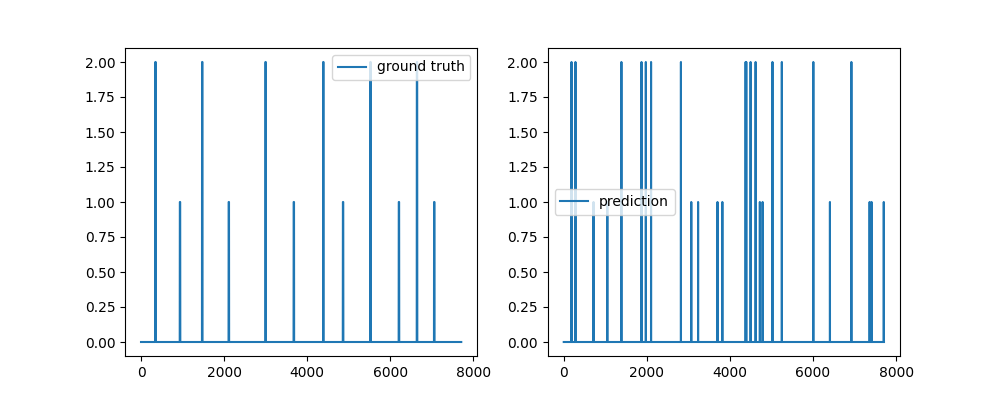

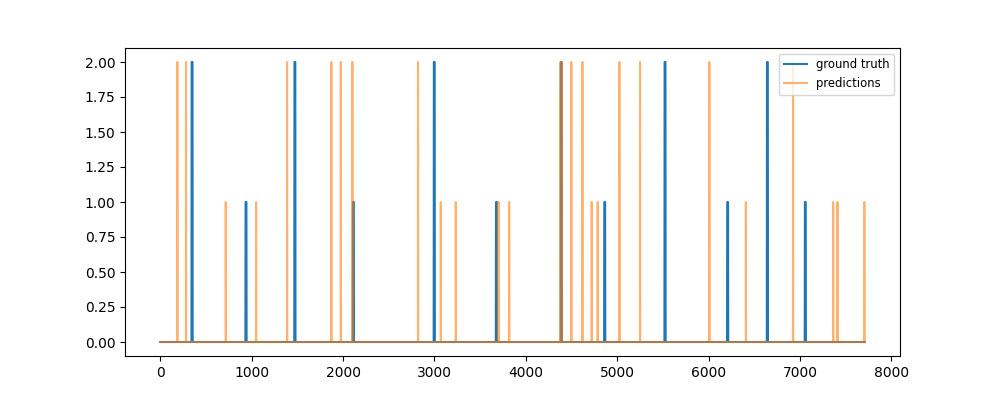

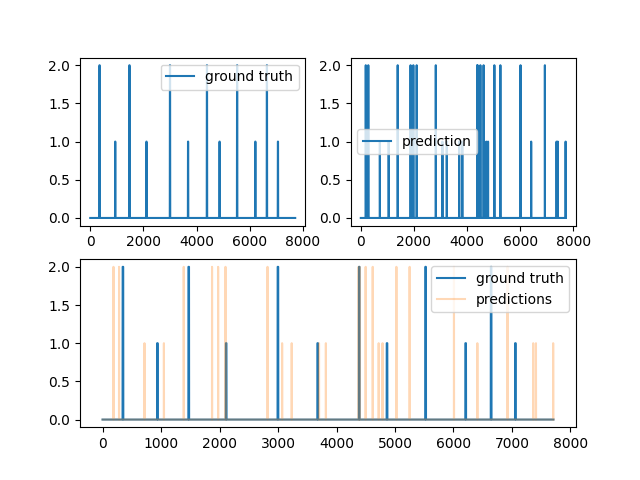

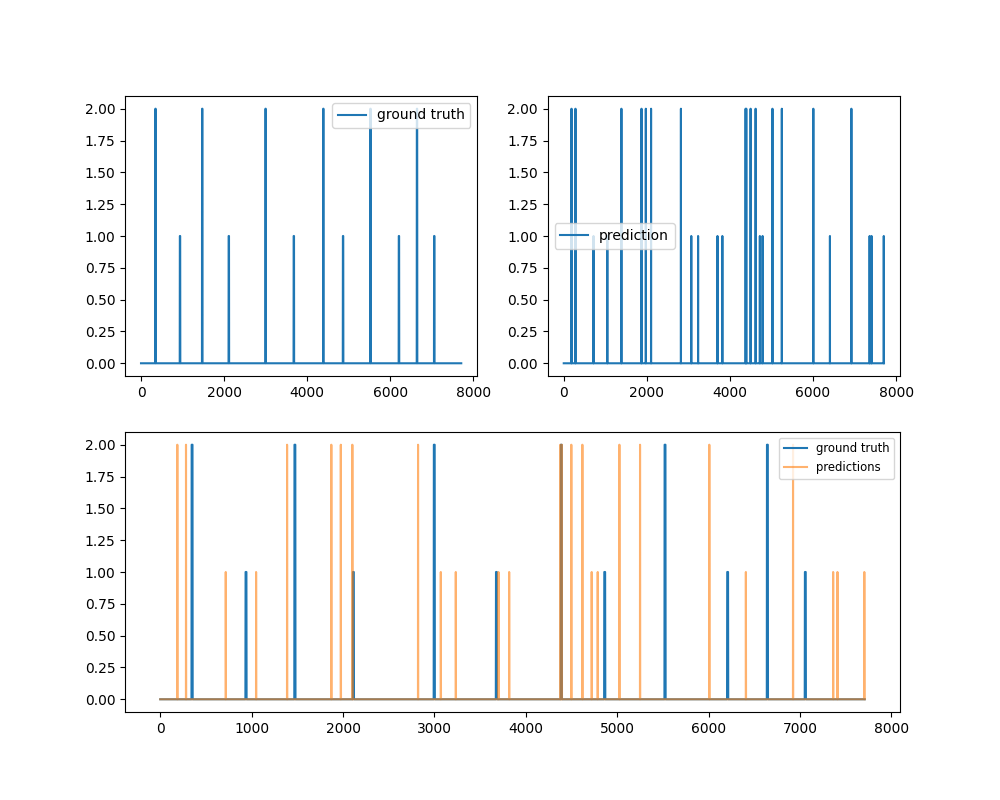

In [13]:
### Visualise ### 
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(predictions, label='prediction')
ax2.legend()

fig2, ax3 = plt.subplots(1,1, figsize=(10,4))
ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')


fig = plt.figure()
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(predictions, label='prediction')
ax2.legend()

# fig2, ax3 = plt.subplots(1,1, figsize=(5,4))
ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.3)
ax3.legend()


####

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(predictions, label='prediction')
ax2.legend()

ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')
